## Kohinoor Chatterjee
## USC ID - 7961357311
## gitusername - kohinoor98

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/My Drive/data')


Mounted at /content/drive


In [2]:
!pip install opencv-python
!pip install opencv-python-headless

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data generation by augmentation

In [4]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


## Train and Test data split for images

In [5]:
classes = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']

def load_data_and_split(path, augment_data=True):
    data = []

    for c in classes:
        class_path = os.path.join(path, c)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                img_resized = cv2.resize(img, (256, 256))

                if augment_data:
                    img_resized = data_gen.random_transform(img_resized)

                data.append((img_resized, classes.index(c)))

    random.shuffle(data)
    
    num_data = len(data)
    train_data = data[:ceil(0.7*num_data)]
    val_data = data[ceil(0.7*num_data):ceil(0.85*num_data)]
    test_data = data[ceil(0.85*num_data):]

    return train_data, val_data, test_data

In [6]:
data_path = '/content/drive/My Drive/data/Sport Images'
train_data, val_data, test_data = load_data_and_split(data_path)

## Visualizing train and test data

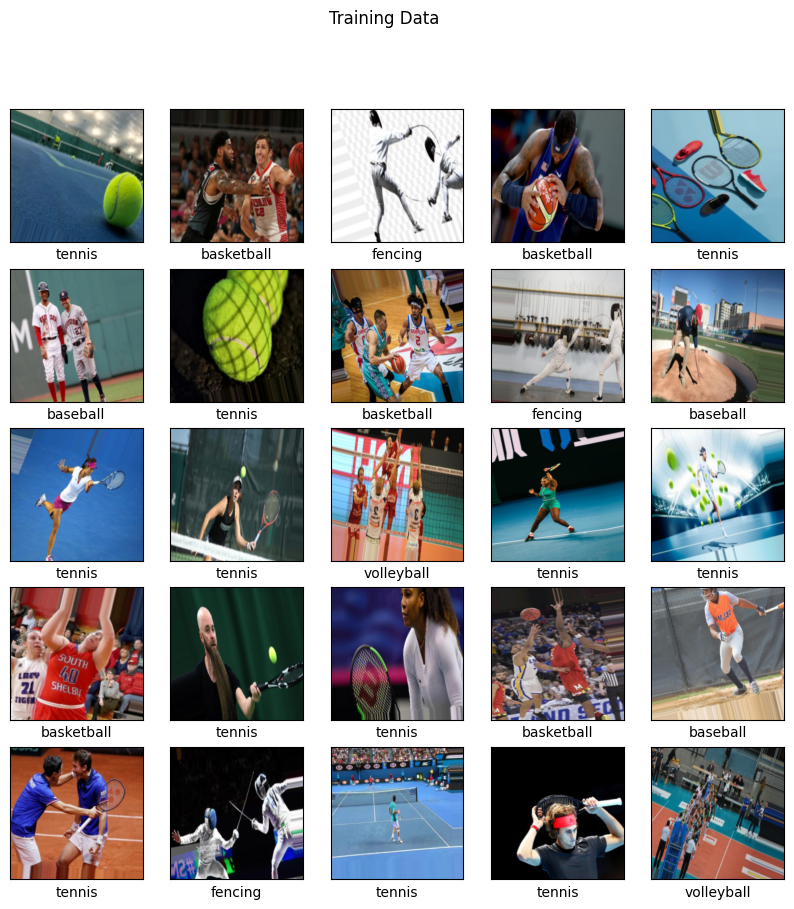

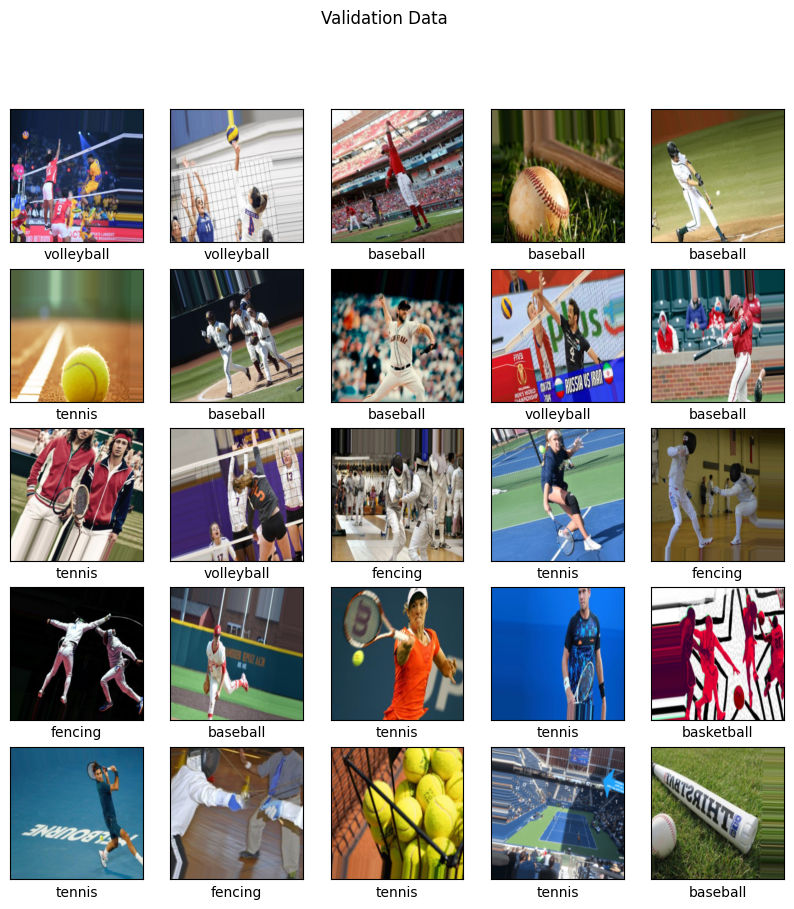

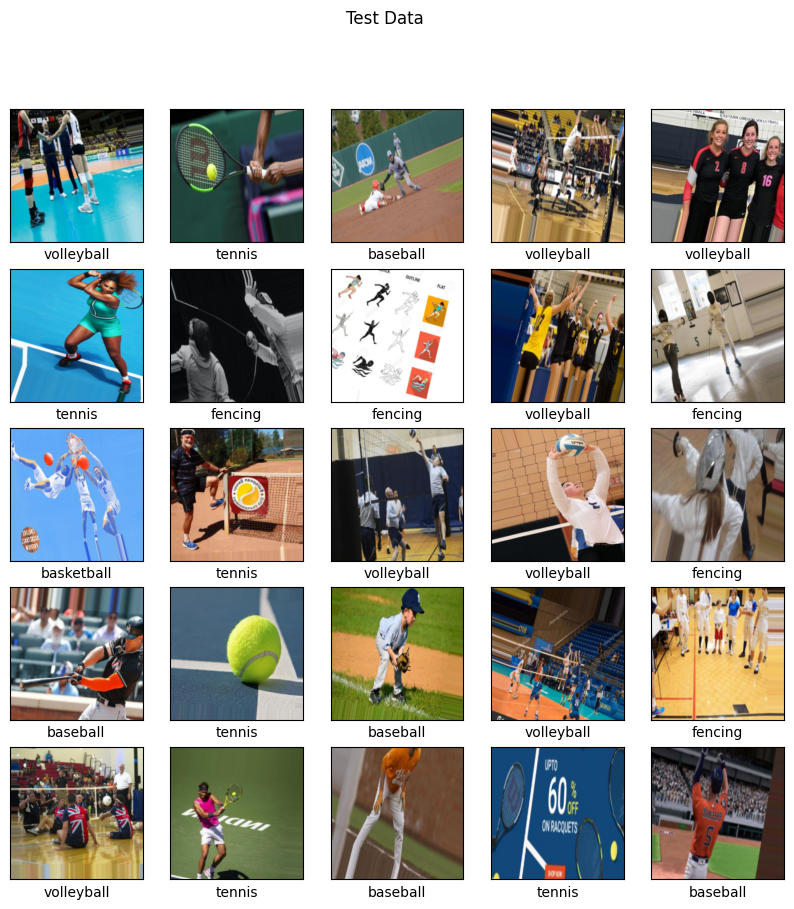

In [7]:
def plot_images(data, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(cv2.cvtColor(data[i][0], cv2.COLOR_BGR2RGB))
        plt.xlabel(classes[data[i][1]])
    plt.suptitle(title)
    plt.show()

plot_images(train_data, "Training Data")
plot_images(val_data, "Validation Data")
plot_images(test_data, "Test Data")


In [8]:
!pip install -U tensorflow keras opencv-python opencv-python-headless
!pip install -U efficientnet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.7 MB/s eta 0:00:00


In [9]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
import efficientnet.keras as efn


## Preprocess data

In [10]:
def preprocess_data(train_data, val_data, test_data):
    train_X, train_y = zip(*train_data)
    val_X, val_y = zip(*val_data)
    test_X, test_y = zip(*test_data)
    
    lb = LabelBinarizer()
    lb.fit(list(range(5)))

    train_X = np.array(train_X)
    train_y = lb.transform(np.array(train_y))
    
    val_X = np.array(val_X)
    val_y = lb.transform(np.array(val_y))
    
    test_X = np.array(test_X)
    test_y = lb.transform(np.array(test_y))

    return train_X, train_y, val_X, val_y, test_X, test_y

train_X, train_y, val_X, val_y, test_X, test_y = preprocess_data(train_data, val_data, test_data)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(train_X, train_y, batch_size=5)
val_generator = ImageDataGenerator().flow(val_X, val_y, batch_size=5)
test_generator = ImageDataGenerator().flow(test_X, test_y, batch_size=5)


## Create transfer learning models

In [11]:
def create_transfer_learning_model(base_model, num_classes, input_shape):
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


## Function to train and evaluate the models

In [12]:
def train_and_evaluate_model(base_model, model_name, input_shape):
    model = create_transfer_learning_model(base_model, 5, input_shape)

    model.compile(optimizer=optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(train_generator,
                        validation_data=val_generator,
                        steps_per_epoch=len(train_X) // 5,
                        validation_steps=len(val_X) // 5,
                        epochs=100,
                        callbacks=[early_stopping])

    train_y_pred = model.predict(train_X)
    train_y_pred_classes = np.argmax(train_y_pred, axis=1)
    train_y_true_classes = np.argmax(train_y, axis=1)

    test_y_pred = model.predict(test_X)
    test_y_pred_classes = np.argmax(test_y_pred, axis=1)
    test_y_true_classes = np.argmax(test_y, axis=1)

    conf_matrix_train = confusion_matrix(train_y_true_classes, train_y_pred_classes)
    conf_matrix_test = confusion_matrix(test_y_true_classes, test_y_pred_classes)

    precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(train_y_true_classes, train_y_pred_classes, average='weighted')
    precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(test_y_true_classes, test_y_pred_classes, average='weighted')

    accuracy_train = accuracy_score(train_y_true_classes, train_y_pred_classes)
    accuracy_test = accuracy_score(test_y_true_classes, test_y_pred_classes)

    print(f"Model: {model_name}")
    print("Confusion Matrix (Train):")
    print(conf_matrix_train)
    print("Confusion Matrix (Test):")
    print(conf_matrix_test)

    print(f"Precision (Train): {precision_train}")
    print(f"Precision (Test): {precision_test}")

    print(f"Recall (Train): {recall_train}")
    print(f"Recall (Test): {recall_test}")

    print(f"Accuracy (Train): {accuracy_train}")
    print(f"Accuracy (Test): {accuracy_test}")

    print(f"F1 Score (Train): {f1_score_train}")
    print(f"F1 Score (Test): {f1_score_test}")

    # Plot training and validation errors
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss vs. Epochs ({model_name})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model


## Train and evaluate ResNet50 and VGG16 models

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/100
457/457 [==============================] - 59s 91ms/step - loss: 0.7731 - accuracy: 0.7344 - val_loss: 0.3206 - val_accuracy: 0.8866
Epoch 2/100
457/457 [==============================] - 39s 86ms/step - loss: 0.5650 - accuracy: 0.7926 - val_loss: 0.3487 - val_accuracy: 0.8680
Epoch 3/100
457/457 [==============================] - 39s 85ms/step - loss: 0.5291 - accuracy: 0.8136 - val_loss: 0.2384 - val_accuracy: 0.9216
Epoch 4/100
457/457 [==============================] - 39s 86ms/step - loss: 0.5028 - accuracy: 0.8302 - val_loss: 0.2552 - val_accuracy: 0.9031
Epoch 5/100
457/457 [==============================] - 39s 86ms/step - loss: 0.5064 - accuracy: 0.8241 - val_loss: 0.2394 - val_accuracy: 0.9113
Epoch 6/100
457/457 [==============================] - 40s 88ms/step - loss: 0.4942 - accuracy: 0.8276 - val_loss: 0.2036 - val_accuracy: 0.9237
Epoch 7/100
457/457 [==============================] - 40s 88ms/s

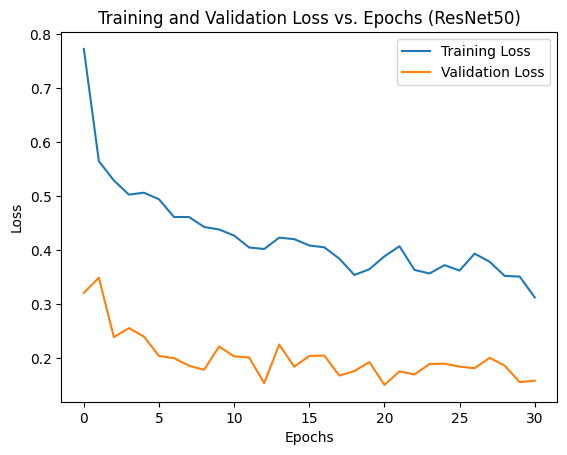

In [13]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet_base.trainable = False
resnet_model = train_and_evaluate_model(resnet_base, "ResNet50", (256, 256, 3))



In [ ]:

# efficientnet_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# efficientnet_base.trainable = False
# efficientnet_model = train_and_evaluate_model(efficientnet_base, "EfficientNetB0", (256, 256, 3))


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/100
457/457 [==============================] - 54s 112ms/step - loss: 0.9338 - accuracy: 0.6573 - val_loss: 0.5329 - val_accuracy: 0.8227
Epoch 2/100
457/457 [==============================] - 43s 93ms/step - loss: 0.6403 - accuracy: 0.7689 - val_loss: 0.4574 - val_accuracy: 0.8577
Epoch 3/100
457/457 [==============================] - 41s 89ms/step - loss: 0.6185 - accuracy: 0.7716 - val_loss: 0.4239 - val_accuracy: 0.8557
Epoch 4/100
457/457 [==============================] - 41s 90ms/step - loss: 0.5523 - accuracy: 0.8066 - val_loss: 0.3665 - val_accuracy: 0.8701
Epoch 5/100
457/457 [==============================] - 41s 89ms/step - loss: 0.5907 - accuracy: 0.8022 - val_loss: 0.3810 - val_accuracy: 0.8680
Epoch 6/100
457/457 [==============================] - 42s 92ms/step - loss: 0.5691 - accuracy: 0.7978 - val_loss: 0.3827 - val_accuracy: 0.8866
Epoch 7/100
457/457 [==============================] - 42s 93ms/

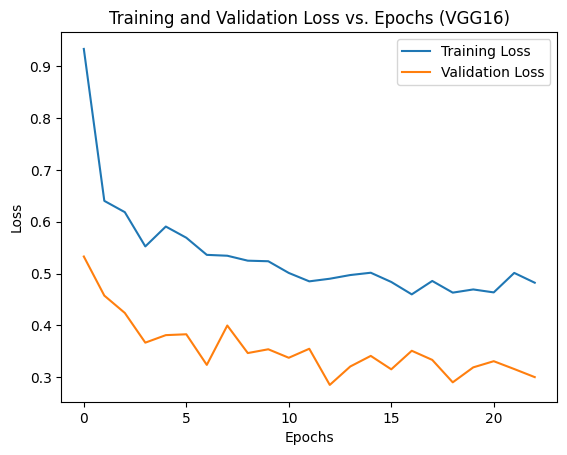

In [15]:

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg_base.trainable = False
vgg_model = train_and_evaluate_model(vgg_base, "VGG16", (256, 256, 3))

## Video frame extraction

In [20]:
import cv2

def extract_frames(video_path, num_frames=100):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    frames = []
    for idx in range(total_frames):
        ret, frame = cap.read()
        if ret and idx in frame_indices:
            frame_resized = cv2.resize(frame, (256, 256))
            frames.append(frame_resized)

    cap.release()
    return np.array(frames)


## Video prediction

In [17]:
def predict_video_frames(model, video_frames):
    predictions = model.predict(video_frames)
    return np.mean(predictions, axis=0)


## Video prediction | evaluation

In [18]:
video_classes = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']
def evaluate_on_videos(model, video_folder):
    video_predictions = []
    video_true_labels = []

    for c_idx, c in enumerate(video_classes):
        class_video_folder = os.path.join(video_folder, c)
        for video_name in os.listdir(class_video_folder):
            video_path = os.path.join(class_video_folder, video_name)
            try:
                video_frames = extract_frames(video_path)
            except Exception as e:
                
            video_prediction = predict_video_frames(model, video_frames)
            video_predictions.append(np.argmax(video_prediction))
            video_true_labels.append(c_idx)

    conf_matrix = confusion_matrix(video_true_labels, video_predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(video_true_labels, video_predictions, average='weighted')
    accuracy = accuracy_score(video_true_labels, video_predictions)

    print("Confusion Matrix:")
    print(conf_matrix)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1_score}")


## Video - ResNet50 and VGG16 models

In [21]:
video_folder = '/content/drive/My Drive/data/Sport Videos'

# resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# resnet_base.trainable = False
# resnet_model = train_and_evaluate_model(resnet_base, "ResNet50", (256, 256, 3))

# efficientnet_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# efficientnet_base.trainable = False
# efficientnet_model = train_and_evaluate_model(efficientnet_base, "EfficientNetB0", (256, 256, 3))

# vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# vgg_base.trainable = False
# vgg_model = train_and_evaluate_model(vgg_base, "VGG16", (256, 256, 3))

# video_folder = '/content/drive/My Drive/data/Sport Videos'

print("Evaluating ResNet50 Model")
evaluate_on_videos(resnet_model, video_folder)



Evaluating ResNet50 Model
4/4 [==============================] - 0s 106ms/step
Confusion Matrix:
[[141   0   6   3   0]
 [ 30   0  61  19  27]
 [ 15   0  96   0   0]
 [ 26   0  21 115   5]
 [  2   0  74   0  40]]
Precision: 0.5062570153870767
Recall: 0.5756240822320118
Accuracy: 0.5756240822320118
F1 Score: 0.5134732380439834


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:

print("\nEvaluating VGG16 Model")
evaluate_on_videos(vgg_model, video_folder)




Evaluating VGG16 Model
4/4 [==============================] - 0s 150ms/step
Confusion Matrix:
[[138   0   6   3   3]
 [ 19   9  62  11  36]
 [  9   0 102   0   0]
 [ 25   0   9 121  12]
 [  3   0  73   0  40]]
Precision: 0.7185023418897194
Recall: 0.6020558002936858
Accuracy: 0.6020558002936858
F1 Score: 0.5554647920482216
